<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTu8IayzMrmGKgbnT0hGkk6k7FhiK1ICbTNUA&usqp=CAU" />

In [5]:
import os
from acquire import test, grab_telco, prep_t, telco_test, split
from env import username, password, host
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

import sklearn.metrics as mtc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

<div class="alert alert-block alert-success">
    
# Business Goals
## - Find drivers for customer churn at Telco. Why are customers churning?
## - Construct a Machine Learning classification model that accurately predicts customer churn.
## - Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?

<div class="alert alert-block alert-info">
    
# Initial Questions:
### Are certain groups (age, gender, etc.) of customers unsatisfied with our service?

### Do we offer products/services(internet types) that do not meet expectations?

### Are we charging too much?

### Do we lack customer support?

### Do we need to put more focus on the types of contracts we offer for customers?

# Acquire and view the data
>We will grab this data from the telco.csv file

In [6]:
telco = grab_telco()
telco.head()

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,No,No,No,Yes,1,No,2,59.9,542.4,No
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes
3,3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,...,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes
4,4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,...,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes


# Look at the column(feature) Dtypes and check for cells with no values (nulls)

In [7]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   customer_id               7043 non-null   object 
 2   gender                    7043 non-null   object 
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   object 
 5   dependents                7043 non-null   object 
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   object 
 8   multiple_lines            7043 non-null   object 
 9   internet_service_type_id  7043 non-null   int64  
 10  online_security           7043 non-null   object 
 11  online_backup             7043 non-null   object 
 12  device_protection         7043 non-null   object 
 13  tech_support              7043 non-null   object 
 14  streamin

---

# Prep the data
>**Create dummy variables for modeling purposes<br>
(1: 'Yes', 0: 'No')**

In [8]:
telco = prep_t(telco)

In [9]:
telco.head(3)

,customer_id,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,streaming_tv_Yes,streaming_movies_Yes,...,churn_Yes,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,online_security_Yes,multiple_lines_Yes
0,0002-ORFBO,0,9,1,2,2,65.6,593.3,1,0,...,0,0,1,1,1,1,0,1,0,0
1,0003-MKNFE,0,9,1,1,2,59.9,542.4,0,1,...,0,1,0,0,1,0,0,0,0,1
2,0004-TLHLJ,0,4,2,1,1,73.9,280.85,0,0,...,1,1,0,0,1,0,1,0,0,0


---

## Separate Customer ID and Total Charges from the data. 
>**The feature is not needed to run tests, but I'd like to still keep it.<br>
<br>
I do not believe Total Charges will aid in the prediction of churn based on how it is defined(the amount of charges over a customers lifetime with Telco**.

In [11]:
customers = telco[['customer_id', 'total_charges']]
customers.head()

,customer_id,total_charges
0,0002-ORFBO,593.3
1,0003-MKNFE,542.4
2,0004-TLHLJ,280.85
3,0011-IGKFF,1237.85
4,0013-EXCHZ,267.4


## ... And then make sure the dataset reflects that change

In [12]:
telco = telco.loc[:, telco.columns != 'total_charges']
telco.head()

,customer_id,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,online_security_Yes,multiple_lines_Yes
0,0002-ORFBO,0,9,1,2,2,65.6,1,0,1,0,0,1,1,1,1,0,1,0,0
1,0003-MKNFE,0,9,1,1,2,59.9,0,1,0,0,1,0,0,1,0,0,0,0,1
2,0004-TLHLJ,0,4,2,1,1,73.9,0,0,1,1,1,0,0,1,0,1,0,0,0
3,0011-IGKFF,1,13,2,1,1,98.0,1,1,1,1,1,1,0,1,1,1,0,0,0
4,0013-EXCHZ,1,3,2,1,2,83.9,1,0,1,1,0,1,0,1,0,0,1,0,0


### Now all features are numerical values

## Additionally, I want to make sure I don't forget what each value represents for the categorical data:

### Internet Service Type:
> 1. DSL
2. Fiber Optic
3. None

### Payment Type: 
> 1. Electronic check
2. Mailed check
3. Bank Transfer
4. CC

### Contract Type: 
> 1. Month-to-Month
2. One-year
3. Two-year

---

# Understand how the data is shaped to make sure it is properly split in Train, Validate, and Test

In [17]:
telco.shape

(7043, 10)

---

# Split the data
>**Train, Validate, and Test**

In [18]:
train, validate, test = split(telco)
train.shape, validate.shape, test.shape

((4225, 10), (1409, 10), (1409, 10))

In [19]:
train.head(3)

,customer_id,internet_service_type_id,payment_type_id,tenure,paperless_billing_Yes,churn_Yes,phone_service_Yes,online_backup_Yes,tech_support_Yes,online_security_Yes
531,0781-LKXBR,2,1,9,1,1,1,0,0,0
484,0707-HOVVN,1,3,70,1,0,1,1,1,0
4224,5960-MVTUK,1,1,3,1,0,0,0,1,0


---

# Find the Baseline
>**Establish the baseline rate of Churn (on train)**

In [20]:
train.churn_Yes.value_counts()

0    3122
1    1103
Name: churn_Yes, dtype: int64

In [23]:
baseline_accuracy = 3122/4225
baseline_accuracy

0.7389349112426036

---

# Run statistical tests to determine initial direction

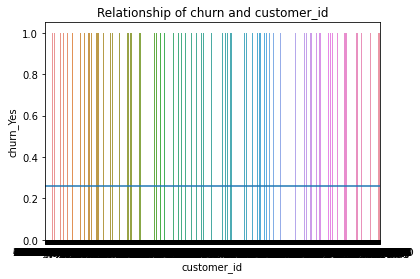

We fail to reject that churn_Yes and customer_id are independent
There appears to be no relationship between customer_id and churn_Yes
None
-------
customer_id  0002-ORFBO  0003-MKNFE  0011-IGKFF  0013-EXCHZ  0013-MHZWF  \
churn_Yes                                                                 
0                     1           1           0           0           1   
1                     0           0           1           1           0   

customer_id  0013-SMEOE  0014-BMAQU  0016-QLJIS  0017-IUDMW  0019-EFAEP  ...  \
churn_Yes                                                                ...   
0                     1           1           1           1           1  ...   
1                     0           0           0           0           0  ...   

customer_id  9972-EWRJS  9972-VAFJJ  9974-JFBHQ  9978-HYCIN  9979-RGMZT  \
churn_Yes                                                                 
0                     1           1           1           1           1   
1    

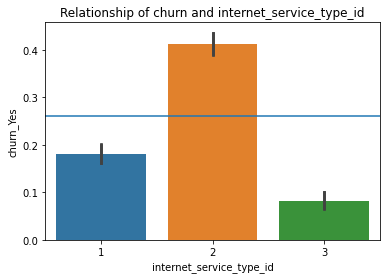

We reject that churn_Yes and internet_service_type_id are independent
There is a relationship between internet_service_type_id and churn_Yes
None
-------
internet_service_type_id     1     2    3
churn_Yes                                
0                         1190  1088  844
1                          263   764   76
-------
(420.39456674873696, 5.1579807793913186e-92, 2, array([[1073.67242604, 1368.50745562,  679.82011834],
       [ 379.32757396,  483.49254438,  240.17988166]]))
-------
2    1852
1    1453
3     920
Name: internet_service_type_id, dtype: int64
2    0.438343
1    0.343905
3    0.217751
Name: internet_service_type_id, dtype: float64


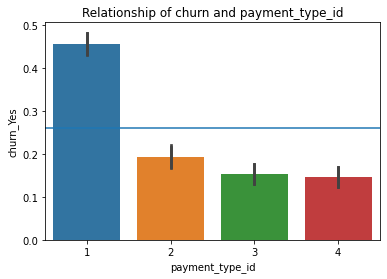

We reject that churn_Yes and payment_type_id are independent
There is a relationship between payment_type_id and churn_Yes
None
-------
payment_type_id    1    2    3    4
churn_Yes                          
0                759  784  789  790
1                636  188  143  136
-------
(416.17159044825945, 6.951899090969447e-90, 3, array([[1030.81420118,  718.24473373,  688.68733728,  684.25372781],
       [ 364.18579882,  253.75526627,  243.31266272,  241.74627219]]))
-------
1    1395
2     972
3     932
4     926
Name: payment_type_id, dtype: int64
1    0.330178
2    0.230059
3    0.220592
4    0.219172
Name: payment_type_id, dtype: float64


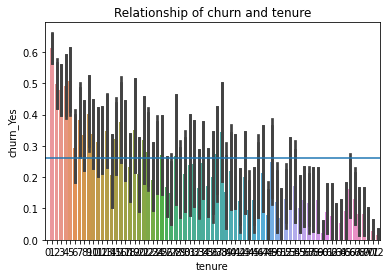

We reject that churn_Yes and tenure are independent
There is a relationship between tenure and churn_Yes
None
-------
tenure     0    1   2   3   4   5   6   7   8   9   ...  63  64  65  66  67  \
churn_Yes                                           ...                       
0           4  146  80  71  51  42  46  42  42  40  ...  42  52  30  46  53   
1           0  232  79  65  49  43  19  26  21  27  ...   2   3   3   9   8   

tenure     68  69  70   71   72  
churn_Yes                        
0          56  55  66  107  198  
1           5   5   3    3    3  

[2 rows x 73 columns]
-------
(682.1308001964724, 3.623487109299768e-100, 72, array([[  2.95573964, 279.31739645, 117.49065089, 100.49514793,
         73.89349112,  62.80946746,  48.03076923,  50.24757396,
         46.55289941,  49.50863905,  54.68118343,  47.29183432,
         48.76970414,  50.98650888,  35.46887574,  45.8139645 ,
         35.46887574,  38.42461538,  41.38035503,  27.34059172,
         31.77420118,  32.5131

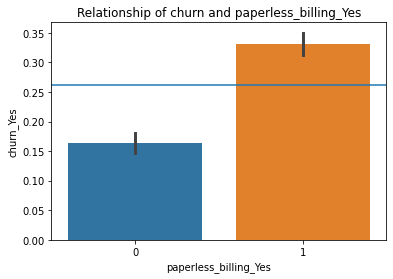

We reject that churn_Yes and paperless_billing_Yes are independent
There is a relationship between paperless_billing_Yes and churn_Yes
None
-------
paperless_billing_Yes     0     1
churn_Yes                        
0                      1467  1655
1                       286   817
-------
(148.04046428468965, 4.648210834341839e-34, 1, array([[1295.35289941, 1826.64710059],
       [ 457.64710059,  645.35289941]]))
-------
1    2472
0    1753
Name: paperless_billing_Yes, dtype: int64
1    0.585089
0    0.414911
Name: paperless_billing_Yes, dtype: float64


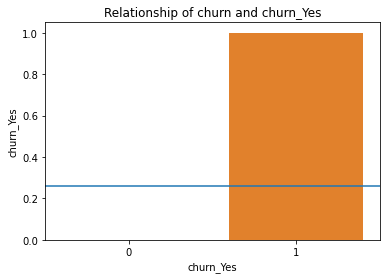

We reject that churn_Yes and churn_Yes are independent
There is a relationship between churn_Yes and churn_Yes
None
-------
churn_Yes     0     1
churn_Yes            
0          3122     0
1             0  1103
-------
(4219.817828480165, 0.0, 1, array([[2306.9547929,  815.0452071],
       [ 815.0452071,  287.9547929]]))
-------
0    3122
1    1103
Name: churn_Yes, dtype: int64
0    0.738935
1    0.261065
Name: churn_Yes, dtype: float64


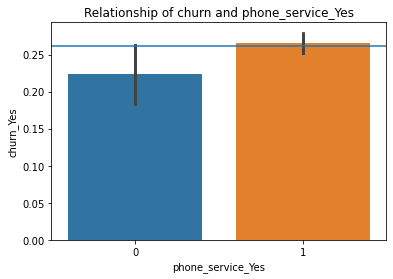

We fail to reject that churn_Yes and phone_service_Yes are independent
There appears to be no relationship between phone_service_Yes and churn_Yes
None
-------
phone_service_Yes    0     1
churn_Yes                   
0                  313  2809
1                   90  1013
-------
(3.0764929409516517, 0.07943163348259978, 1, array([[ 297.79076923, 2824.20923077],
       [ 105.20923077,  997.79076923]]))
-------
1    3822
0     403
Name: phone_service_Yes, dtype: int64
1    0.904615
0    0.095385
Name: phone_service_Yes, dtype: float64


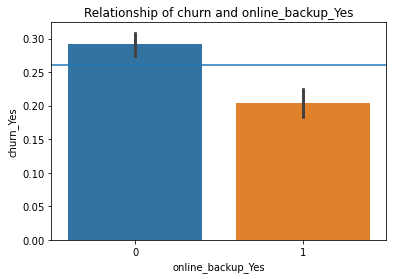

We reject that churn_Yes and online_backup_Yes are independent
There is a relationship between online_backup_Yes and churn_Yes
None
-------
online_backup_Yes     0     1
churn_Yes                    
0                  1957  1165
1                   804   299
-------
(37.05679088359808, 1.1473828582889493e-09, 1, array([[2040.19928994, 1081.80071006],
       [ 720.80071006,  382.19928994]]))
-------
0    2761
1    1464
Name: online_backup_Yes, dtype: int64
0    0.653491
1    0.346509
Name: online_backup_Yes, dtype: float64


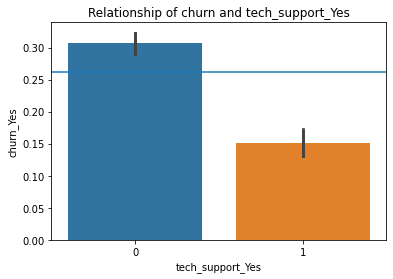

We reject that churn_Yes and tech_support_Yes are independent
There is a relationship between tech_support_Yes and churn_Yes
None
-------
tech_support_Yes     0     1
churn_Yes                   
0                 2071  1051
1                  917   186
-------
(110.30343475198362, 8.408281328424107e-26, 1, array([[2207.93751479,  914.06248521],
       [ 780.06248521,  322.93751479]]))
-------
0    2988
1    1237
Name: tech_support_Yes, dtype: int64
0    0.707219
1    0.292781
Name: tech_support_Yes, dtype: float64


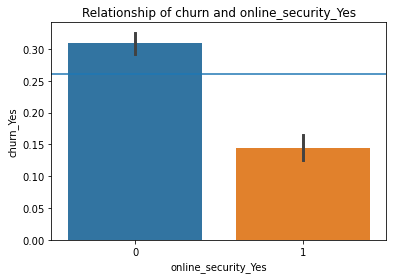

We reject that churn_Yes and online_security_Yes are independent
There is a relationship between online_security_Yes and churn_Yes
None
-------
online_security_Yes     0     1
churn_Yes                      
0                    2066  1056
1                     924   179
-------
(121.14110968945856, 3.5589563395146736e-28, 1, array([[2209.41538462,  912.58461538],
       [ 780.58461538,  322.41538462]]))
-------
0    2990
1    1235
Name: online_security_Yes, dtype: int64
0    0.707692
1    0.292308
Name: online_security_Yes, dtype: float64


In [56]:
telco_test(train)

<div class="alert alert-block alert-success">
    
## For now, I want to focus on:
**Internet Service Type:**<br>
> Fiber Optic reprsents almost half of customers, yet churn at over twice the rate of other internet types.<br>

**Online Backup:**<br>
> The population without online back is twice as large as those who do, yet churn 10% more.

**Device Protection:**<br>
> 2/3 of customer don't have device protection and churn more often that those who do, it could be beneficial to target them.

**Tech Support:**<br>
> Almost 3/4 of customers don't utilize Tech Support and churn twice as often as those who do

**Online Security:**<br>
> Over 70% of customer do not have Online security yet churn twice as fast as those who do.

**Payment Type:**
> Electronic Check payments churn at almost 2.5x the rate of any other payment method and represent a third of all customers.
    
**Age:**<br>
> Senior Citizens are twice as likely to churn than their younger counter parts.

**Tenure:**<br>
> It's clear that long-term customers are less and less likely to churn over time.



### I chose these features based on the statistical relationship coupled with the proportion of each features 'Yes' or 'No'
### I decided against using the rest of the features due to either lack of relationship or other factors that cannot be controlled
> **Example**: Dependents, those with no dependents churn at twice the rate of those who do have dependents, but that does not indicate the reason thye do so.

# Focus on those features

In [14]:
train = train[['customer_id', 
               'internet_service_type_id',
               'payment_type_id',
               'tenure',
               'paperless_billing_Yes',
               'churn_Yes',
               'phone_service_Yes',
               'online_backup_Yes',
               'tech_support_Yes',
               'online_security_Yes']
             ]

validate = validate[['customer_id', 
               'internet_service_type_id',
               'payment_type_id',
               'tenure',
               'paperless_billing_Yes',
               'churn_Yes',
               'phone_service_Yes',
               'online_backup_Yes',
               'tech_support_Yes',
               'online_security_Yes']
             ]

test = test[['customer_id', 
               'internet_service_type_id',
               'payment_type_id',
               'tenure',
               'paperless_billing_Yes',
               'churn_Yes',
               'phone_service_Yes',
               'online_backup_Yes',
               'tech_support_Yes',
               'online_security_Yes']
             ]

,customer_id,internet_service_type_id,payment_type_id,tenure,paperless_billing_Yes,churn_Yes,phone_service_Yes,online_backup_Yes,tech_support_Yes,online_security_Yes
0,0002-ORFBO,1,2,9,1,0,1,1,1,0
1,0003-MKNFE,1,2,9,0,0,1,0,0,0
2,0004-TLHLJ,2,1,4,1,1,1,0,0,0


# Set the X,Y Train
>**Dropping churn from x train<br>
Additionally, Customer ID needs to be separated before models are made**

In [24]:
x_train = train.drop(columns=['churn_Yes', 'customer_id'])
y_train = train.churn_Yes
train_id = train.customer_id

x_validate = validate.drop(columns=['churn_Yes', 'customer_id'])
y_validate = validate.churn_Yes
validate_id = validate.customer_id

x_test = test.drop(columns=['churn_Yes', 'customer_id'])
y_test = test.churn_Yes
test_id = test.customer_id

---

# Best 3 Models Discovered

>### Decision Tree (max_depth=3)<br>
>### KNN (nearest 10)<br>
>### Logistic Regression

# Decision Tree
### I used a low depth to avoid overfitting

In [25]:
tree = DecisionTreeClassifier(max_depth=3)

In [26]:
tree = tree.fit(x_train, y_train)
y_predict = tree.predict(x_train)
y_pred_prob = tree.predict_proba(x_train)

In [27]:
cm = pd.DataFrame(confusion_matrix(y_train, y_predict))

## Train
**Model Score**: 79.67% <br>
**Precision**: 82%<br>
**Recall**: 93% <br>
**F1 Score**: 87%

In [28]:
print(classification_report(y_train, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3122
           1       0.68      0.41      0.51      1103

    accuracy                           0.80      4225
   macro avg       0.75      0.67      0.69      4225
weighted avg       0.78      0.80      0.78      4225



## Validate
**Model Score**: 77.50%<br>
**Precision**: 80%<br>
**Recall**: 93%<br>
**F1 Score**: 86%

In [29]:
y_pred_val = tree.predict(x_validate)
print(classification_report(y_validate, y_pred_val))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1020
           1       0.67      0.37      0.48       389

    accuracy                           0.78      1409
   macro avg       0.73      0.65      0.67      1409
weighted avg       0.76      0.78      0.75      1409



---

# Logistic Regression

In [30]:
logit = LogisticRegression(random_state=248)

In [31]:
logit.fit(x_train, y_train)

LogisticRegression(random_state=248)

In [32]:
y_pred_lr = logit.predict(x_train)

## Train

**Model/Accuracy Score**: 78%<br>
**Precision**: 81%<br>
**Recall**: 91%<br>
**F1 Score**: 86%

In [34]:
print(classification_report(y_train, y_pred_lr))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3122
           1       0.61      0.40      0.48      1103

    accuracy                           0.78      4225
   macro avg       0.71      0.65      0.67      4225
weighted avg       0.76      0.78      0.76      4225



## Validate

**Model/Accuracy Score**: 75%<br>
**Precision**: 79%<br>
**Recall**: 90%<br>
**F1 Score**: 84%

In [35]:
y_pred_lr_val = logit.predict(x_validate)

In [36]:
print(classification_report(y_validate, y_pred_lr_val))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1020
           1       0.58      0.37      0.45       389

    accuracy                           0.75      1409
   macro avg       0.68      0.63      0.65      1409
weighted avg       0.73      0.75      0.73      1409



---

# KNN (nearest 10)

In [37]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn = knn.fit(x_train, y_train)

In [38]:
y_predict_knn = knn.predict(x_train)

In [39]:
y_pred_prob_knn = knn.predict_proba(x_train)

## Train

**Model/Accuracy Score**: 81%<br>
**Precision**: 83%<br>
**Recall**: 93%<br>
**F1 Score**: 88%

In [40]:
print(classification_report(y_train, y_predict_knn))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3122
           1       0.71      0.47      0.57      1103

    accuracy                           0.81      4225
   macro avg       0.77      0.70      0.72      4225
weighted avg       0.80      0.81      0.80      4225



## Validate

**Model/Accuracy Score**: 77%<br>
**Precision**: 80%<br>
**Recall**: 90%<br>
**F1 Score**: 85%

In [41]:
y_predict_knn_val = knn.predict(x_validate)

In [42]:
print(classification_report(y_validate, y_predict_knn_val))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1020
           1       0.62      0.40      0.48       389

    accuracy                           0.77      1409
   macro avg       0.71      0.65      0.67      1409
weighted avg       0.75      0.77      0.75      1409



# The Overall Best Model is... Decision Tree

 ### Test:
**Model Score**: 79%<br>
**Precision**: 81%<br>
**Recall**: 92%<br>
**F1 Score**: 86%

In [44]:
y_pred_test = tree.predict(x_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1032
           1       0.66      0.43      0.52       377

    accuracy                           0.79      1409
   macro avg       0.74      0.67      0.69      1409
weighted avg       0.77      0.79      0.77      1409



<div class="alert alert-block alert-warning">

# Recommendations:
    
> **Focus efforts on offering discounted or free online security<br>
    Same for Tech Support**

# If I could do further analysis, I would explore tenure and age more closely

### Those who are senior citizens are about 16% of customers, but churn twice as much as their younger counterparts
### See more precisely in tenure to target to keep customers early on
### Understand why those opted into paperless billing churn at high rates

---